# Data Space Report


<img src="images/polito_logo.png" alt="Polito Logo" style="width: 200px;"/>


## Pittsburgh Bridges Data Set

<img src="images/andy_warhol_bridge.jpg" alt="Andy Warhol Bridge" style="width: 200px;"/>

    Andy Warhol Bridge - Pittsburgh.

Report created by Student Francesco Maria Chiarlo s253666, for A.A 2019/2020.

**Abstract**:The aim of this report is to evaluate the effectiveness of distinct, different statistical learning approaches, in particular focusing on their characteristics as well as on their advantages and backwards when applied onto a relatively small dataset as the one employed within this report, that is Pittsburgh Bridgesdataset.

**Key words**:Statistical Learning, Machine Learning, Bridge Design.

### Imports Section <a class="anchor" id="imports-section"></a>

In [1]:
# =========================================================================== #
# STANDARD IMPORTS
# =========================================================================== #
print(__doc__)

# Critical Imports
# --------------------------------------------------------------------------- #
import warnings; warnings.filterwarnings("ignore")

# Imports through 'from' syntax
# --------------------------------------------------------------------------- #
from pprint import pprint
from itertools import islice
from os import listdir; from os.path import isfile, join
# Standard Imports
# --------------------------------------------------------------------------- #
import copy; import os
import sys; import time
import itertools
import sklearn

# Imports through 'as' syntax
# --------------------------------------------------------------------------- #
import numpy as np; import pandas as pd

# Imports for handling graphics
# --------------------------------------------------------------------------- #
%matplotlib inline
# Matplotlib pyplot provides plotting API
import matplotlib as mpl
from matplotlib import pyplot as plt
import chart_studio.plotly.plotly as py
import seaborn as sns;  sns.set(style="ticks", color_codes=True) # sns.set()

Automatically created module for IPython interactive environment


In [2]:
# =========================================================================== #
# UTILS IMPORTS (Done by myself)
# =========================================================================== #
from utils.load_dataset_pittsburg_utils import load_brdiges_dataset; from utils.display_utils import *
from utils.preprocessing_utils import *; from utils.training_utils import *
from utils.sklearn_functions_custom import *; from utils.learning_curves_custom import *
from utils.training_utils_v2 import fit_by_n_components, fit_all_by_n_components, grid_search_all_by_n_components

In [3]:
# =========================================================================== #
# sklearn IMPORT
# =========================================================================== #
from sklearn.decomposition import PCA, KernelPCA

# Import scikit-learn classes: models (Estimators).
from sklearn.naive_bayes import GaussianNB, MultinomialNB   # Non-parametric Generative Model
from sklearn.linear_model import LogisticRegression         # Parametric Linear Discriminative Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC                          # Parametric Linear Discriminative "Support Vector Classifier"
from sklearn.tree import DecisionTreeClassifier      # Non-parametric Model
from sklearn.ensemble import RandomForestClassifier  # Non-parametric Model (Meta-Estimator, that is, an Ensemble Method)

In [4]:
# =========================================================================== #
# READ INPUT DATASET
# =========================================================================== #

dataset_path = 'C:\\Users\\Francesco\Documents\\datasets\\pittsburgh_dataset'
dataset_name = 'bridges.data.csv'

TARGET_COL = 'T-OR-D'  # Target variable name
dataset, feature_vs_values = load_brdiges_dataset(dataset_path, dataset_name)

In [5]:
columns_2_avoid = ['ERECTED', 'LENGTH', 'LOCATION']

In [6]:
# Make distinction between Target Variable and Predictors
# --------------------------------------------------------------------------- #

columns = dataset.columns  # List of all attribute names

# Get Target values and map to 0s and 1s
# y = np.array(list(map(lambda x: 0 if x == 1 else 1, dataset[TARGET_COL].values)))
y = np.array(list(map(lambda x: -1 if x == 1 else 1, dataset[TARGET_COL].values)))
print('Summary about Target Variable {target_col}')
print('-' * 50)
print(dataset[TARGET_COL].value_counts())

# Get Predictors
X = dataset.loc[:, dataset.columns != TARGET_COL].values

Summary about Target Variable {target_col}
--------------------------------------------------
2    57
1    13
Name: T-OR-D, dtype: int64


In [7]:
# Standardizing the features
# --------------------------------------------------------------------------- #
scaler_methods = ['minmax', 'standard', 'norm']
scaler_method = 'standard'
rescaledX = preprocessing_data_rescaling(scaler_method, X)

shape features matrix X, after normalizing:  (70, 11)


## Pricipal Component Analysis

In [8]:
n_components = rescaledX.shape[1]
pca = PCA(n_components=n_components)
# pca = PCA(n_components=2)

# X_pca = pca.fit_transform(X)
pca = pca.fit(rescaledX)
X_pca = pca.transform(rescaledX)

In [9]:
print(f"Cumulative varation explained(percentage) up to given number of pcs:")

tmp_data = []
principal_components = [pc for pc in '2,5,6,7,8,9,10'.split(',')]
for _, pc in enumerate(principal_components):
    n_components = int(pc)
    
    cum_var_exp_up_to_n_pcs = np.cumsum(pca.explained_variance_ratio_)[n_components-1]
    # print(f"Cumulative varation explained up to {n_components} pcs = {cum_var_exp_up_to_n_pcs}")
    # print(f"# pcs {n_components}: {cum_var_exp_up_to_n_pcs*100:.2f}%")
    tmp_data.append([n_components, cum_var_exp_up_to_n_pcs * 100])

tmp_df = pd.DataFrame(data=tmp_data, columns=['# PCS', 'Cumulative Varation Explained (percentage)'])
tmp_df.head(len(tmp_data))

Cumulative varation explained(percentage) up to given number of pcs:


,# PCS,Cumulative Varation Explained (percentage)
0,2,47.738342
1,5,75.856460
2,6,82.615768
3,7,88.413903
4,8,92.661938
5,9,95.976841
6,10,98.432807


#### Major Pros & Cons of PCA



## Learning Models <a class="anchor" id="learning-models"></a>

In [15]:
# Parameters to be tested for Cross-Validation Approach

estimators_list = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), SGDClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
estimators_names = ['GaussianNB', 'LogRegr', 'Knn', 'SGD', 'SVC', 'DecisionTree', 'RandomForest']
plots_names = list(map(lambda xi: f"{xi}_learning_curve.png", estimators_names))

pca_kernels_list = ['linear', 'poly', 'rbf', 'cosine', 'sigmoid']
cv_list = [10, 9, 8, 7, 6, 5, 4, 3, 2]

parmas_logistic_regression = {
    'penalty': ('l1', 'l2', 'elastic', None),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'fit_intercept': (True, False),
    'tol': (1e-4, 1e-3, 1e-2),
    'class_weight': (None, 'balanced'),
    'C': (10.0, 1.0, .1, .01, .001, .0001),
    'random_state': (0,),
}


parmas_knn_forest = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),
    'weights': ('uniform', 'distance'),
    'metric': ('euclidean', 'minkowski', 'manhattan'),
    'leaf_size': (5, 10, 15, 30),
    'algorithm': ('ball_tree', 'kd_tree', 'brute'),
}

parameters_sgd_classifier = {
    'loss': ('log', 'modified_huber'), # ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
    'penalty': ('l2', 'l1', 'elasticnet'),
    'alpha': (1e-1, 1e-2, 1e-3, 1e-4),
    'max_iter': (50, 100, 150, 200, 500, 1000, 1500, 2000, 2500),
    'learning_rate': ('optimal',),
    'tol': (None, 1e-2, 1e-4, 1e-5, 1e-6)
}

kernel_type = 'svm-rbf-kernel'
parameters_svm = {
    'gamma': (0.003, 0.03, 0.05, 0.5, 0.7, 1.0, 1.5),
    'max_iter':(1e+2, 1e+3, 2 * 1e+3, 5 * 1e+3, 1e+4, 1.5 * 1e+3),
    # 'penalty': ('l2','l1'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'C': (1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3),
    'probability': (True,), 
}

parmas_decision_tree = {
    'splitter': ('random', 'best'),
    'criterion':('gini', 'entropy'),
    'max_features': (None, 'auto', 'sqrt', 'log2')
}

parmas_random_forest = {
    'n_estimators': (3, 5, 7, 10, 30, 50, 70, 100, 150, 200),
    'criterion':('gini', 'entropy'),
    'bootstrap': (True, False)
}

param_grids = [parmas_logistic_regression, parmas_knn_forest, parameters_sgd_classifier, parameters_svm, parmas_decision_tree, parmas_random_forest]

N_CV, N_KERNEL, N_GS = 9, 4, 6

In [16]:
n_components=9
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=np.linspace(.1, 1.0, 10),
    n_components=9,
    pca_kernels_list=pca_kernels_list[0],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='accuracy',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}"), ignore_func=True,
    # figsize=(20,5)
)

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Kernel PCA: Linear | LogRegr
[*] Best Score:
0.9714285714285715


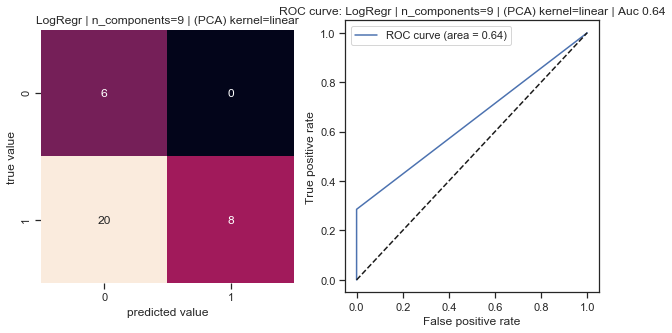

Kernel PCA: Poly | LogRegr
[*] Best Score:
0.9178571428571429


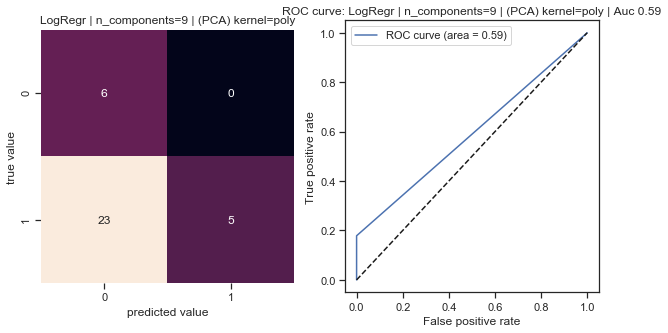

Kernel PCA: Rbf | LogRegr
[*] Best Score:
0.9214285714285715


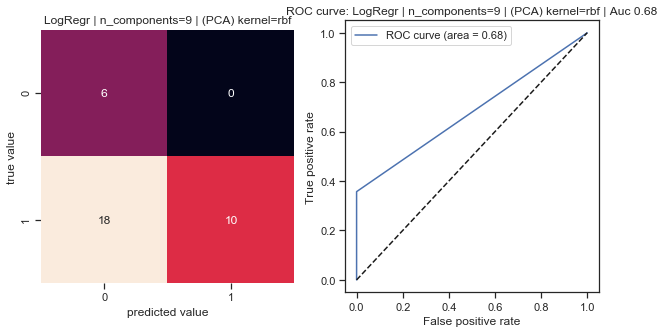

Kernel PCA: Cosine | LogRegr
[*] Best Score:
0.9214285714285715


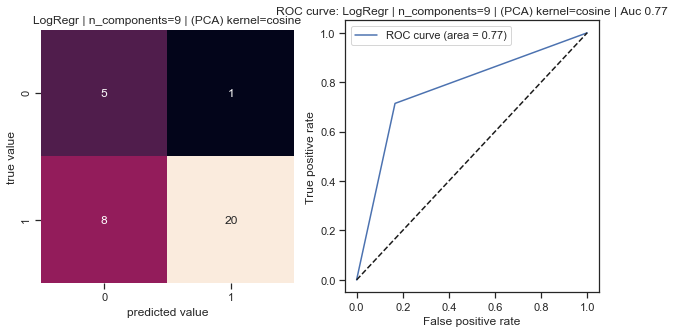

Kernel PCA: Sigmoid | LogRegr
[*] Best Score:
0.9142857142857143


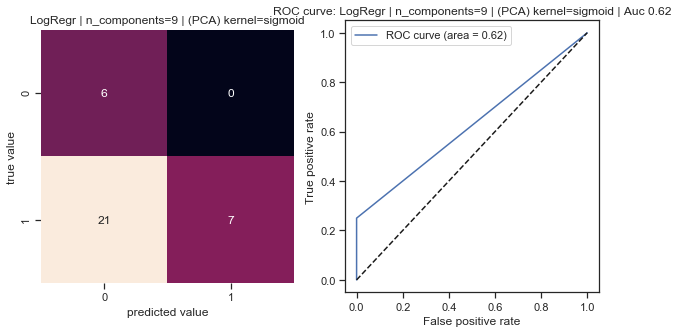

In [18]:
plot_dest = os.path.join("figures", "n_comp_9_analysis", "grid_search")
X = rescaledX

df_gs, df_auc_gs = grid_search_all_by_n_components(
    estimators_list=estimators_list[1], \
    param_grids=param_grids[0],
    estimators_names=estimators_names[1], \
    X=X, y=y,
    n_components=9,
    random_state=0, show_plots=False, show_errors=False, verbose=1, plot_dest=plot_dest, debug_var=False)
df_9, df_9_auc = df_gs, df_auc_gs

Looking at the results obtained running *Logistic Regression Classifier* against our dataset splitted into training set and test set and adopting a different kernel trick applied to *kernel-Pca* unsupervised preprocessing method we can state that generally speaking all the methods shonw a very high *Train Accuracy Score*  which reaches in the most of the case a value greater than *90%*. However only one trial out of five, that is trial in which we adopted *Cosine Trick* we was able to account for *74%* of accuracy than the other cases where instead we do not reach a *train accuracy score* greater than *50%*. So, we can end up saying that the other models either overfit to the *train set* and wasn't able to generalize well on *test set*, or the fact that our dataset is not a balanced one leads to models and estimators that were able to correctly predict one among the two classes and more specifically, the models seems to recognize better the *class 0*, that is *Deck Bridges* than *class 1*, that is *Through Bridges*. In other words, usually working with unbalanced dataset we expect that the most frequent classes or most numerous classes were advantaged against the less numerous, but here emploping Logisti Regression Classifier we obtained models that were more able to correctly classify the less numerous class and to worngly predict the more numerous class. More precisely:
- speaking about __Linear kernel Pca based Logisti Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches a poor test accuracy score of just *41%* with respect to a train accuracy score of *97%*. The model indeed overfits to the overall train set and tends to better predict the less numerous class, so the model gains weight parameters suitable to identify class 0 samples. Looking at *recall and precision scores*, the model was really precise when predicting class 1 examples and was able to correcly predict labels for class 0, so maximzes recall of negative class. But we cannot say it is also precise when predicting class 0 this means that it wrongly inferes the true label for positive class. Lastly the model obtained high and low weighted average precision and recall, such that weigthed *F1-score* was low as well. Speaking about *Roc curve and Auc Score*, we can unbderstand that the model obtains a intermediate Auc score, of *.64* than the Random Classifier, and the relationship between *FPR and TPR* is linear most of the time changing the threshold value for classification.
- observing __Polynomial kernel Pca based Logisti Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches even a lower test accuracy of *32%* than a still high train accuracy of *91%*. So also here for this trial the resulting model overfit to the train set and becaus of both lower accuracy scores we can can state that the model wrongly predicts a larger number of samples from class 1. In fact the model's precision and recall of class 0 and class 1 lowered than the values seens for the previous trial, while the precision and recall of class 1 and class 0 still remain the same, so this model preidcts with high precision samples from class 1 but with great uncertainty about class 0, even if most of the sample from such a classes were correctly labeled. Looking at *Roc Curve and Auc Score* we can observe that the best found model with this configuration indeed is going slightly bettere than random classifier, in fact has a auc score equals just to *.59* and the *TPR and FPR* behaviors is that them grows linearly while modifying the default threshold value most of the time.
- review __Rbf kernel Pca based Logisti Classifier__, we can stricly and briefly saying that as the two preivous models also here discussing this estimator performance we do not obtain satisfying results in fact the model behaves more or less as the first reviewed, and more precisely the model obtained a slighlty better accuracy on test set of *.47* and a weighted F1-Score of *.5*, that allow for a Auc score that reaches a value of *.68* However also this model overfit to the train set with an accuracy score of *92%*, and is more able to correcly predict class 1 instances with high precision and class 0 instances with more uncertainty, even if has a high recall related to class 0.
- __Cosine kernel Pca based Logisti Classifier__ results to be the best solution found while performing grid search algorithm for Logisti Regression method, when it is fixed a defualt threshold of *.5* for classification. The rationale is that this trial retrieves a model that does not overfit to the train set, since test set accuracy is *74%*, just nearly 20 percent points than train accuracy score of *92%*. Moreover, we obtain high values for both *averaged precions, recalla and F1-Score metrics*, where the latter more precisely was even gretaer than test accuracy score, reachiung a value of *77%*. However, this model as others is less precise when predicting labels for class 0, than when inferring class 1 lables, this is mostly due to the fact that the dataset is not balanced. So we still remain more confident and precise when predicting class labels for class 1 examples. Looking at Roc Curve and Auc Score, we can say that for this model we have a curve which is able to account for up to *77%* of auc, and that this model works fine for many thresholds, in particular we can imagine to lower down a little bit the default threshold so that we can improve *TPR* reducing slightly *FPR* scores.
- lastly, also __Sigmoid kernel Pca based Logisti Classifier__ as other previous trials except the one represented by the moedl trained fixing Cosine Trick as kernel Pca method, gains poor and lower performance, due to overfit issue and as other more or less same low performance models generally speaking obtains high and low weighted average precision and recall scores, meaning that while the few instances predicted as belonging to class 1 was done with high precision instead of samples from class 0 which was prediceted with high uncertainty, even if most of the time the model correctly predicts instances that indeed belongs to class 0. The Roc Curve and Auc Score of *62%* show that also this run leads to a model which TPR and FPR are most of the time growing linearly across the thresholds.

In [19]:
create_widget_list_df([df_gs, df_auc_gs]) #print(df_gs); print(df_auc_gs)

Looking at the table dispalyed just above that shows the details about the selected values for hyper-parameters specified during grid search, in the different situations accordingly to the fixed kernel-trick for kernel Pca unsupervised method we can state that, referring to the first two columns of *Train and Test Accuracy*, we can recognize which trials lead to more overfit results such as for *Linear, Polynomial, Rbf, and Sigmoid Tricks* or less overfit solution such as in the case of *Cosine Trick*. Speaking about the hyper-parameters, we can say what follows:
- speaking about the *hyper-param C*, that is inverse of regularization strength where smaller values specify stronger regularization, we observe that except the Cosine kernel trick case all other kernel-Pca tricks adopted have preferred to exploit a very low value for *C parameter* equals to *0.001* and accounts for a very strtong regularization, but such a choice does not lead to models that obtained a high generalization capability, instead the *Cosine based kernel-Pca* model opted for a default value for such a parameter.
- instead referring to *class_weight parameter*, we knwo that it can be set with balanced strategy which stends for a strategy where values of y to automatically adjust weights inversely proportional to class frequencies in the input data as *n_samples / (n_classes * np.bincount(y))*, we have been surprised that all the method that obtained worst performance choose a balanced strategy than the best model which was fine even with a default strategy that does not require to use a balanced mode.
- instead *fit_intercept parameter* refers to the fact that we specify if a constant (a.k.a. bias or intercept) should be added to the decision function, and allows for modeling a certain behavior and a certain response different from zero even when the input sample is mostly made of zero components, we can understand that in all the cases the models obtained best results enabling such strategy and so the models are fitted taking into account also a intercept weight or parameter, increasing model complexity.
- model's *penalty parameter* allows to specify the norm used in the penalization, among the folowing list of possible choices *l1, l2, elasticnet*. In all the models the best choice was for *l2 regularization*, this means that all the models opted for a kind of regularization that do not consider at all the *l1 normalization* as a regularization technique, so we avoid to obtain models that instead may lead weights to zero values, in other words sparse models.
- model's *solver parameter* which is the algorithm to use in the optimization problem. It is curios to notice that almost all the models except cosine based kernel-Pca which adopted *liblinear* solver. What we can understand is that for all the overfitted models the choice of *sag* solver does not lead to significant results in term of performance, and we can say instead that we correctly except that for such a small dataset a *liblinear* choice is the most suitable and the best model found here is coherent with such a suggestion from theory field.
- lastly, looking at *tol parameter*, which stends for tolerance for stopping criteria, we can clearly see that the first two models adopted a lowe tolerance value instead the last three preferred a lower value of tolerance, so the first two methods accordingly with the kind of kernel trick technique adopted for kernel-Pca seem to go well when a tolerance value is not so small as the last three methods, furthermore the first two methods request less time than the last three because of the lareger tolerance set for training convergence.

### Improvements and Conclusions <a class="anchor" id="Improvements-and-conclusions"></a>

### References  <a class="anchor" id="references"></a>
- Data Domain Information part:
    - (Deck) https://en.wikipedia.org/wiki/Deck_(bridge)
    - (Cantilever bridge) https://en.wikipedia.org/wiki/Cantilever_bridge
    - (Arch bridge) https://en.wikipedia.org/wiki/Deck_(bridge)
- Machine Learning part:
    - (Theory Book) https://jakevdp.github.io/PythonDataScienceHandbook/
    - (Decsion Trees) https://scikit-learn.org/stable/modules/tree.html#tree
    - (SVM) https://scikit-learn.org/stable/modules/svm.html
    - (PCA) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Chart part:
    - (Seaborn Charts) https://acadgild.com/blog/data-visualization-using-matplotlib-and-seaborn
- Markdown Math part:
    - https://share.cocalc.com/share/b4a30ed038ee41d868dad094193ac462ccd228e2/Homework%20/HW%201.2%20-%20Markdown%20and%20LaTeX%20Cheatsheet.ipynb?viewer=share
    - https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html
    
#### others
- Plots:
    - (Python Plot) https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=255798340456&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=1008025&gclid=Cj0KCQjw-_j1BRDkARIsAJcfmTFu4LAUDhRGK2D027PHiqIPSlxK3ud87Ek_lwOu8rt8A8YLrjFiHqsaAoLDEALw_wcB
- Third Party Library:
    - (statsmodels) https://www.statsmodels.org/stable/index.html#
- KDE:
    - (TUTORIAL) https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- Metrics:
    - (F1-Accuracy-Precision-Recall) https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c